Universidad del Valle <br>
Deep Learning <br>
Integrantes:

* Marco Jurado 20308
* Diego Cordova 20212
* Paola Contreras 20213
* Paola de Leon 20361
* Cristian Aguirre 20231

# Parte 1. Practica

In [1]:
# !pip install gymnasium
# !pip install torch

### 1. Importar librerias

In [2]:
import math
import torch
import random
import numpy as np
import torch.nn as nn
import gymnasium as gym
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import namedtuple


### 2. Crear el entorno CartPole

In [3]:
env = gym.make('CartPole-v1')

### 3. Definan las redes en línea y de destino

In [4]:
class Q_network(nn.Module):
    def __init__(self, input_size, output_size):
        super(Q_network, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 4. Hiperparámetros

In [5]:
ur = 0.005 # update rate
steps = 0
Gamma = 0.999
device = "cpu"
batch_size = 128
end_epsilon = 0.05
start_epsilon = 0.9
decay_epsilon = 1000


input_size = env.action_space.n
state, info = env.reset()
output_size = len(state)


policy_net = Q_network(output_size, input_size).to(device)
target_net = Q_network(output_size, input_size).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=0.0001, amsgrad=True)


### 5. Epsilon épsilon-greedy

In [6]:
def select_action(state):
    global steps

    eps_threshold = end_epsilon + (start_epsilon - end_epsilon) * math.exp(-1. * steps / decay_epsilon)
    steps += 1

    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


### 6. Defina la reproducción de la experiencia (experience replay)

In [7]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class EReplay:
    def __init__(self, capacity):
        self.memory = []
        self.capacity = capacity

    # Agregar transicion
    def push(self, *args):
        if len(self.memory) < self.capacity:
          self.memory.append(Transition(*args))

    # Obtener sample
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

memory = EReplay(10000)

### 7. Ciclo de entrenamiento

In [8]:
import matplotlib
import matplotlib.pyplot as plt

episode_durations = []

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [9]:
def train():
    if len(memory.memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * Gamma) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### 8. Representar el entorno

In [10]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

### 9. Supervisar el entrenamiento

In [11]:
for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    t = 0
    while True:
        t += 1
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state
        train()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*ur + target_net_state_dict[key]*(1-ur)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

plt.ioff()
plt.show()

<Figure size 640x480 with 0 Axes>

### 10. Evalúe el rendimiento

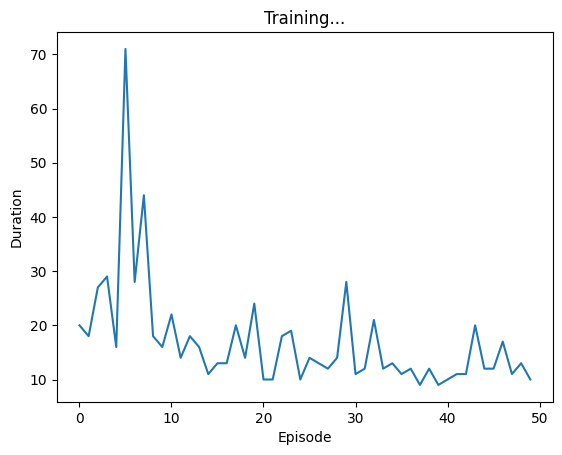

<Figure size 640x480 with 0 Axes>

In [12]:
if done:
    plot_durations()


### 11. Fine-Tuning


# Parte 2. Teoria

Defina en qué consiste y en qué clase de problemas se pueden usar cada uno de los siguientes acercamientos en
Deep Reinforcement Learning


**1. Proximal Policy Optimization**



**2. Deep Deterministic Policy Gradients (DDPG)**



**3. Trust Region Policy Optimization (TRPO)**



**4. Asynchronous Advantage Actor-Critic (A3C)**

